# Seizure detection sandbox

In [28]:
%load_ext autoreload
%autoreload 2

## Workspace Preparation

In [1]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
from kneed import KneeLocator

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns
from sklearn.linear_model import LinearRegression


# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
from os.path import join as ospj
from utils import *
import sys
from seizure_detection_pipeline_pre_train import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

sys.path.append('/users/wojemann/DSOSD/')
from DSOSD.model import NDD

2025-05-13 09:17:45.320051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 09:17:48.181322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
set_seed(5210)

In [5]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP238'
montage = 'bipolar'

In [6]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))


In [7]:
sorted(consensus_annots.patient)

['CHOP005',
 'CHOP010',
 'CHOP015',
 'CHOP015',
 'CHOP024',
 'CHOP026',
 'CHOP026',
 'CHOP028',
 'CHOP028',
 'CHOP035',
 'CHOP035',
 'CHOP037',
 'CHOP037',
 'CHOP038',
 'CHOP038',
 'CHOP041',
 'CHOP041',
 'CHOP045',
 'CHOP046',
 'CHOP046',
 'CHOP049',
 'CHOP049',
 'HUP224',
 'HUP224',
 'HUP224',
 'HUP224',
 'HUP225',
 'HUP225',
 'HUP225',
 'HUP225',
 'HUP229',
 'HUP229',
 'HUP230',
 'HUP230',
 'HUP230',
 'HUP230',
 'HUP235',
 'HUP235',
 'HUP235',
 'HUP235',
 'HUP238',
 'HUP238',
 'HUP238',
 'HUP238',
 'HUP246',
 'HUP246',
 'HUP247',
 'HUP247',
 'HUP247',
 'HUP247',
 'HUP249',
 'HUP249',
 'HUP249',
 'HUP249',
 'HUP250',
 'HUP250',
 'HUP250',
 'HUP250',
 'HUP253',
 'HUP253',
 'HUP253',
 'HUP253',
 'HUP257',
 'HUP257',
 'HUP257',
 'HUP257',
 'HUP261',
 'HUP261',
 'HUP263',
 'HUP263',
 'HUP263',
 'HUP266',
 'HUP266',
 'HUP266',
 'HUP266',
 'HUP267',
 'HUP267',
 'HUP273',
 'HUP273',
 'HUP273',
 'HUP275',
 'HUP275',
 'HUP275',
 'HUP288',
 'HUP288']

In [8]:
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)

consensus_annots[consensus_annots.patient == 'HUP238'][['ueo_chs','sec_chs']]

,ueo_chs,sec_chs
40,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LB01, LB02, LC01, LC02, LC03, LI01]"
41,"[LB01, LB02, LC01, LC02]","[LA01, LA02, LB01, LB02, LC01, LC02, LC03, LG0..."
42,"[LC01, LC02]","[LB01, LB02, LC01, LC02, LG01, LG02, LI01]"
43,"[LC01, LC02]","[LA01, LA02, LB01, LB02, LB03, LC01, LC02, LC0..."


## Data Loading

In [9]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [10]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter_raw = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [11]:
electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
if pt[:3] == 'CHO':
    suffix = ['CHOPR','CHOPM']
else:
    suffix = ['dkt','atropos']
electrode_localizations.name = clean_labels(electrode_localizations.name,pt) #don't end up using grey/white matter
electrode_regions.name = clean_labels(electrode_regions.name,pt)
electrode_localizations.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[1]}.pkl')) #don't end up using grey/white matter
electrode_regions.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[0]}.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter_raw.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter_neural = inter_raw[neural_channels]

In [12]:
# inter_neural.iloc[:,:22] = inter_neural.iloc[:,:22]*1e-3

In [13]:
inter_prep,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

Text(0.5, 0, 'Time (s)')

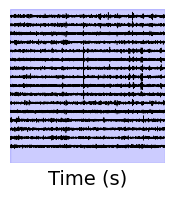

In [14]:
if pt == 'HUP238':
    elements = ['LC01-LC02', 'LC03-LC04', 'LC02-LC03', 'LI01-LI02', 'LB02-LB03',
        'LB01-LB02', 'LB03-LB04', 'LA01-LA02', 'LU01-LU02', 'LA03-LA04',
        'LA04-LA05', 'LI02-LI03', 'LA02-LA03', 'LT01-LT02', 'LI03-LI04',
        'LI06-LI07', 'LI07-LI08', 'LI05-LI06', 'LI04-LI05', 'LI08-LI09']
    elements_clean = [e for e in elements if e in inter_prep.columns]
    elements_sorted = np.sort(elements_clean)
    plot_iEEG_data(inter_prep.loc[:,elements_sorted],fs,minmax=True,fig_size=(2,2),empty=True)
else:
    plot_iEEG_data(inter_prep,fs,minmax=True,fig_size=(4,4),empty=True)

plt.yticks([])
plt.xticks([])
plt.axvspan(0,len(inter_prep)/fs,color='blue',alpha=0.2)
plt.xlabel('Time (s)')
# plt.savefig(ospj(figpath,'interictal_baseline_example.pdf'),bbox_inches='tight')

Text(0.5, 0, 'Time (s)')

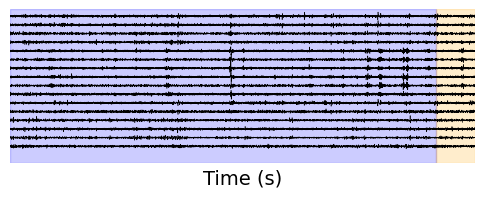

In [15]:
if pt == 'HUP238':
    elements = ['LC01-LC02', 'LC03-LC04', 'LC02-LC03', 'LI01-LI02', 'LB02-LB03',
        'LB01-LB02', 'LB03-LB04', 'LA01-LA02', 'LU01-LU02', 'LA03-LA04',
        'LA04-LA05', 'LI02-LI03', 'LA02-LA03', 'LT01-LT02', 'LI03-LI04',
        'LI06-LI07', 'LI07-LI08', 'LI05-LI06', 'LI04-LI05', 'LI08-LI09']
    elements_clean = [e for e in elements if e in inter_prep.columns]
    elements_sorted = np.sort(elements_clean)
    plot_iEEG_data(inter_prep.loc[:,elements_sorted],fs,minmax=True,fig_size=(6,2),empty=True)
else:
    plot_iEEG_data(inter_prep,fs,minmax=True,fig_size=(4,4),empty=True)

plt.yticks([])
plt.xticks([])
plt.axvspan(0,len(inter_prep)/fs-5,color='blue',alpha=0.2)
plt.axvspan(len(inter_prep)/fs-5,len(inter_prep)/fs,color='orange',alpha=0.2)
plt.xlabel('Time (s)')
# plt.savefig(ospj(figpath,'epoch_testing_interictal.pdf'),bbox_inches='tight')

In [16]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [17]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=2:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    print(task)
    break

  0%|          | 0/13 [00:00<?, ?it/s]

ictal294225


In [18]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# seizure_neural.loc[:,:22] = seizure_neural.iloc[:,:22]*1e-3
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [19]:
seizure_prep,fs = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=128)

In [20]:
seizure_prep.max()
noisy_channel_mask = seizure_prep.abs().max() <= (np.median(seizure_prep.abs().max())*50)
seizure_prep.columns[~noisy_channel_mask]
seizure_slice = seizure_prep.loc[120*fs:len(seizure_prep)-(120*fs),:]
seizure_prep = seizure_prep.loc[:,noisy_channel_mask]

Text(0.5, 0, 'Time (s)')

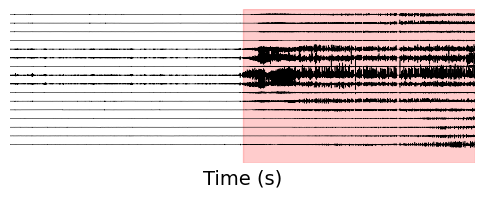

In [21]:
if pt == 'HUP238':   
    plot_iEEG_data(seizure_prep.loc[60*fs:180*fs,elements_sorted],fs,t_offset=-60,minmax=False,fig_size=(6,2),empty=True)
else:
    plot_iEEG_data(seizure_prep.loc[60*fs:180*fs,:],fs,t_offset=-60,minmax=False,fig_size=(6,4),empty=True)
plt.yticks([])
plt.xticks([])
plt.axvspan(0,len(inter_prep)/fs,color='red',alpha=0.2)
plt.xlabel('Time (s)')
# plt.savefig(ospj(figpath,'ictal_seizure_example.pdf'),bbox_inches='tight')

## Plotting

In [22]:
model= LTI(1,.5,128)
model.fit(inter_prep.loc[:,noisy_channel_mask])

([], [])

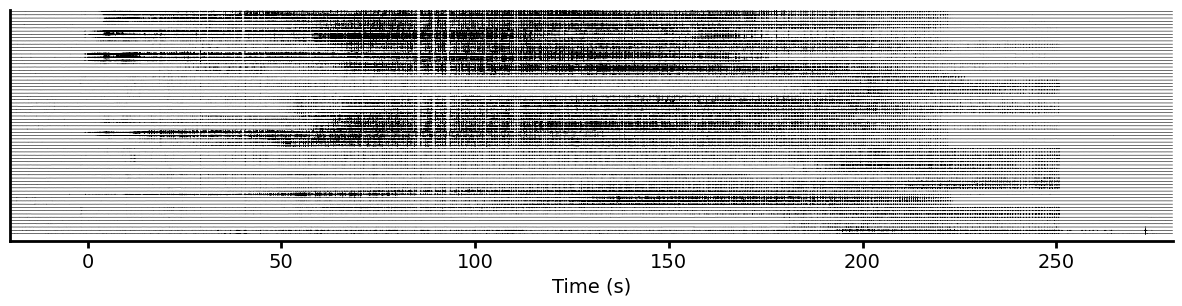

In [23]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 100) & (plot_time < 400)
plot_iEEG_data(plot_data.loc[plot_inds,:],fs,fig_size=(15,3),t_offset=-20)
plt.yticks([])
# plt.savefig(ospj(figpath,'full_seizure_example.pdf'),bbox_inches='tight')

([], [])

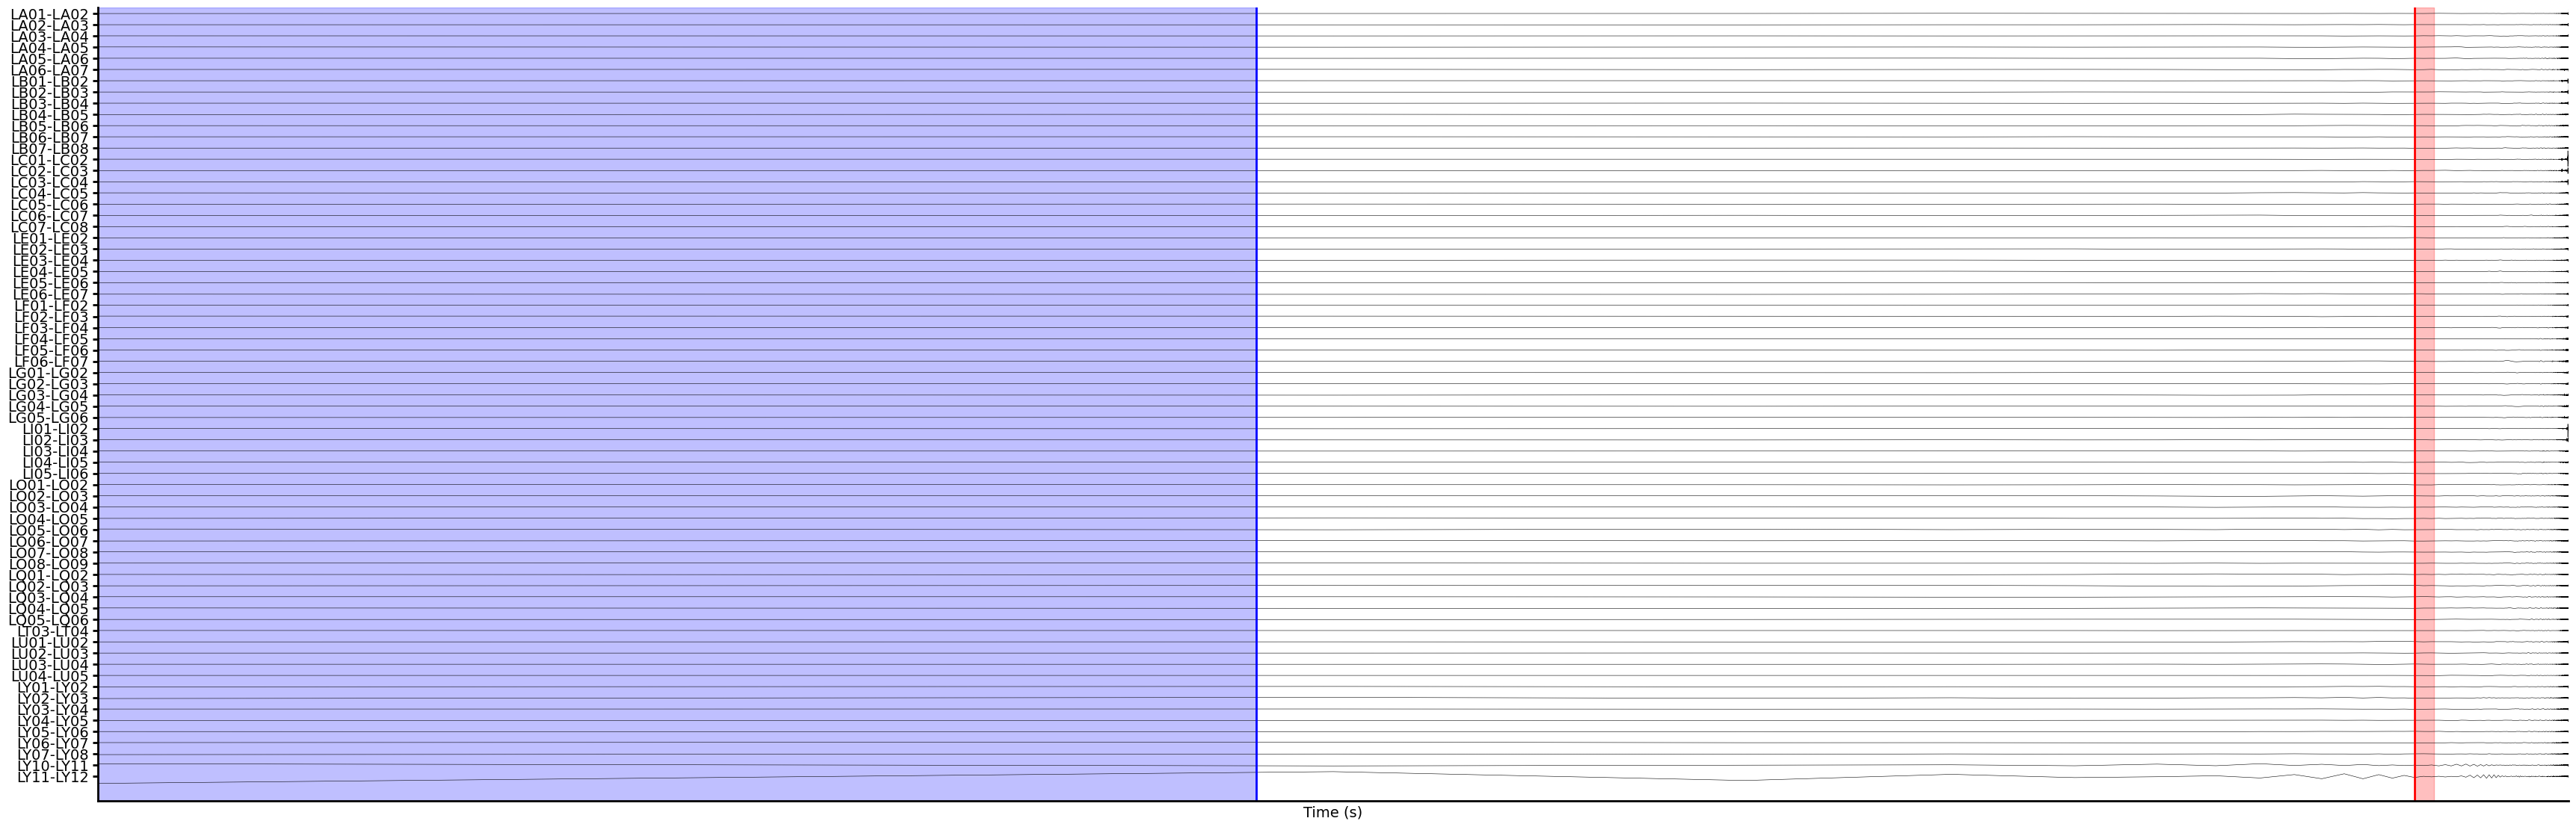

In [24]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 0) & (plot_time < 150)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds])
plt.axvline(0,color='blue')
plt.axvline(60,color='blue')
plt.axvspan(0,60,color='blue',alpha=0.25)
plt.axvline(120,color='red')
# plt.axvline(130,color='red')
plt.axvspan(120,121,color='red',alpha=0.25)
# plt.axvspan(130,131,color='red',alpha=0.25)
plt.xticks([])
# plt.savefig(ospj(figpath,'example_seizure_onset.pdf'))

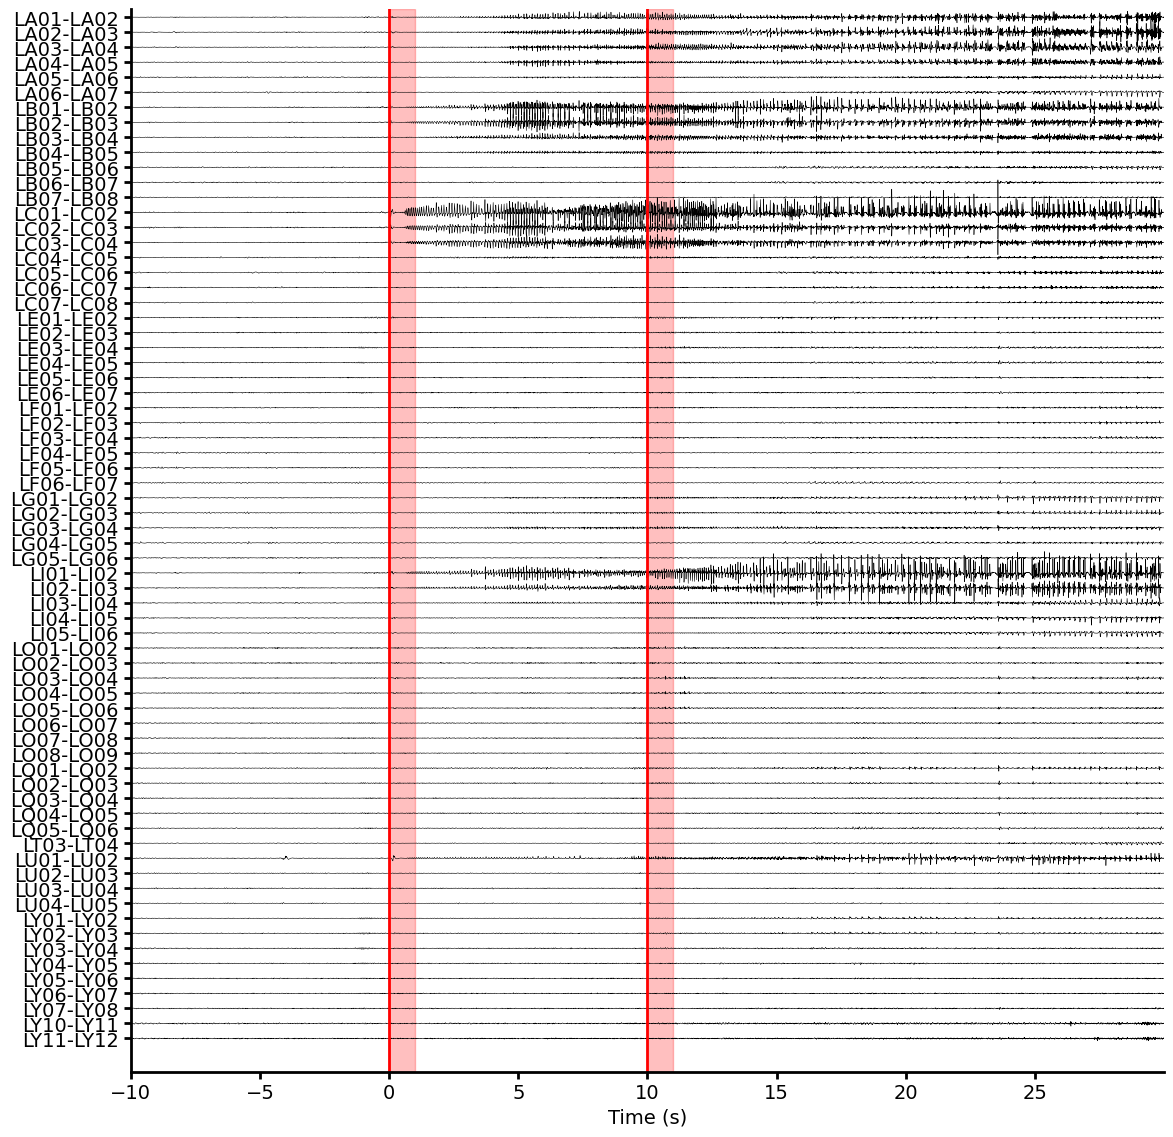

In [25]:
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 110) & (plot_time < 160)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds],t_offset=-10)
plt.axvline(0,color='red')
plt.axvline(10,color='red')
plt.axvspan(0,1,color='red',alpha=0.25)
plt.axvspan(10,11,color='red',alpha=0.25)
# plt.xticks([])
# plt.savefig(ospj(figpath,'example_seizure_just_onset.pdf'))

In [26]:
sz_prob_plot = pd.read_pickle('/mnt/sauce/littlab/users/wojemann/stim-seizures/PROCESSED_DATA/HUP238/pretrain_probability_matrix_nosmooth_mdl-LSTM_fs-128_montage-bipolar_task-ictal294225_run-00.pkl')
sz_prob_times = sz_prob_plot.pop('time').to_numpy()

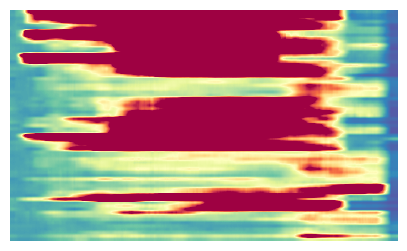

In [29]:
plot_mat = sc.ndimage.uniform_filter1d(sz_prob_plot.iloc[220:-220].to_numpy().T,20)
fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(plot_mat,vmin=0,vmax=5,aspect='auto',cmap='Spectral_r')
for spine in ax.spines.values():
            spine.set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
# fig.savefig(ospj(figpath,'full_prob_example_shrunk.pdf'),bbox_inches='tight')
plt.show()

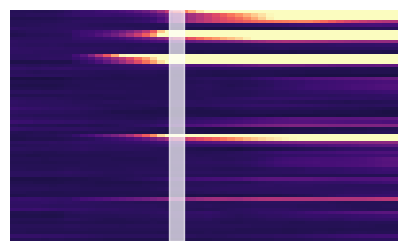

In [29]:
plot_mat = sc.ndimage.uniform_filter1d(sz_prob_plot.iloc[220:270].to_numpy().T,20)
fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(plot_mat,vmin=0,vmax=5,aspect='auto')
for spine in ax.spines.values():
            spine.set_visible(False)
ax.axvspan(20,22,color='white',alpha=0.7)
ax.set_yticks([])
ax.set_xticks([])
fig.savefig(ospj(figpath,'full_prob_example_shrunk_wonset.pdf'),bbox_inches='tight')
plt.show()

In [30]:
prob_mat = sc.ndimage.uniform_filter1d(sz_prob_plot.to_numpy(),20,axis=0)
model = NDD(fs=128)
sz_spread,plot_mat = model.get_onset_and_spread(pd.DataFrame(prob_mat,columns=sz_prob_plot.columns),threshold = 2.451268,ret_smooth_mat=True)

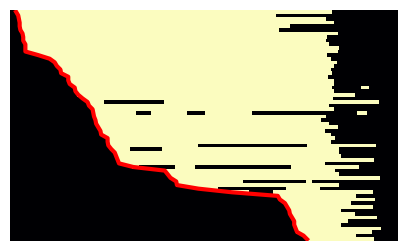

In [31]:
fig,ax = plt.subplots(figsize=(5,3))
ax.matshow(plot_mat.loc[:,sz_spread.columns].iloc[220:-220,:].T,vmin=0,vmax=1,aspect='auto',interpolation='none')
for spine in ax.spines.values():
            spine.set_visible(False)
ax.set_xticks([])
# ax.plot(sz_prob_times[sz_spread.to_numpy().flatten()].reshape(-1,)+1-110,np.arange(len(sz_spread.columns)),color='red',linewidth=3)
ax.plot(sz_spread.to_numpy().reshape(-1,)+1-220,np.arange(len(sz_spread.columns)),color='red',linewidth=3)
ax.set_yticks([])

# fig.savefig(ospj(figpath,'full_clf_example_shrunk.pdf'),bbox_inches='tight')
plt.show()

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Time (s)'>)

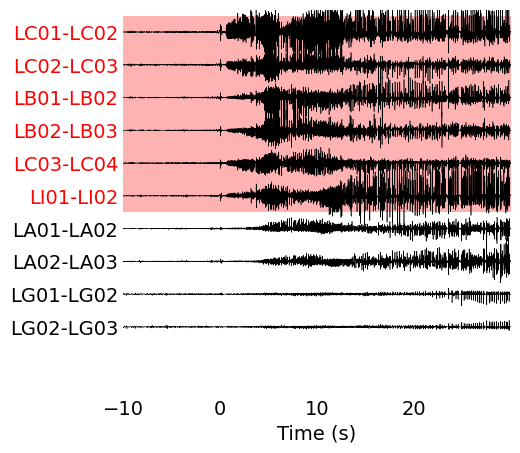

In [32]:
elements = ['LC01-LC02',
 'LC02-LC03',
 'LB01-LB02',
 'LB02-LB03',
 'LC03-LC04',
 'LI01-LI02',
 'LA01-LA02',
 'LA02-LA03',
 'LG01-LG02',
 'LG02-LG03',
 ]
# ['LA01' 'LA02' 'LB01' 'LB02' 'LC01' 'LC02' 'LC03' 'LG01' 'LG02' 'LI01']
color_idxs = ['red' if c in ['LC01-LC02','LC02-LC03','LC03-LC04','LB01-LB02','LB02-LB03','LI01-LI02'] 
 else None for c in elements]
plot_iEEG_data(plot_data.loc[plot_inds,elements],plot_time[plot_inds],
                t_offset=-10,
                shade_color = color_idxs,
                fig_size = (5,5),
                empty = True,
                colors = color_idxs,)
# plt.savefig(ospj(figpath,'example_annotation.pdf'),bbox_inches='tight')

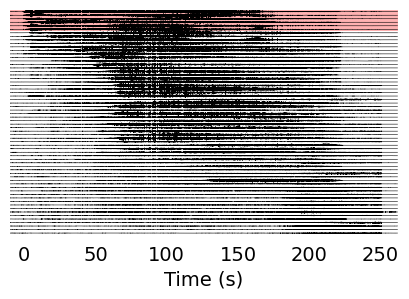

In [35]:
full_plot_inds = (plot_time > 110) & (plot_time < (max(plot_time)-110))
color_idxs = ['red' if c in ['LC01-LC02','LC02-LC03','LC03-LC04','LB01-LB02','LB02-LB03','LI01-LI02'] 
 else None for c in sz_spread.columns]
fig,ax = plot_iEEG_data(plot_data.loc[full_plot_inds,noisy_channel_mask].loc[:,sz_spread.columns],
                        fs,
                        t_offset = -10,
                        shade_color = color_idxs,
                        fig_size = (5,3),
                        empty = True,
                        )
# ax.plot(sz_prob_times[sz_spread.to_numpy().flatten()].reshape(-1,)-111,ax.get_yticks(),color='red',linewidth=3)

ax.set_yticks([])
fig.savefig(ospj(figpath,'full_annot_example_shrunk.pdf'),bbox_inches='tight')

plt.show()

## DSOSD Package

In [35]:
# model = NDD(fs=128,hidden_size=10,num_epochs=10,
# train_win = 12,pred_win=1,
# w_size=1,w_stride=0.5,
# use_cuda=True,
# )
model = NDD(fs=128)
model.fit(seizure_prep.loc[:fs*120/2,:])

# generate seizure likelihood feature (NDD)
sz_prob = model(seizure_prep)

In [36]:
sz_prob_times = model.get_win_times(len(seizure_prep))
time_mask = (sz_prob_times >= 60) & (sz_prob_times <= 180)
onset_idx = np.argmin(np.abs(sz_prob_times - 120)) - np.where(time_mask)[0][0]

In [37]:
threshold = model.get_gaussianx_threshold(sz_prob.iloc[:,:],noise_floor='automedian',verbose=True)
# threshold = model.get_cval_threshold()
threshold

3.48094110881911

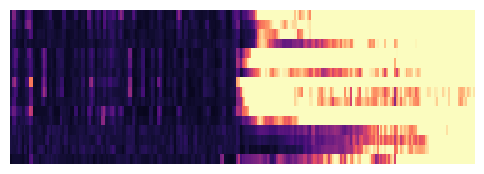

In [38]:
_,ax = plt.subplots(figsize=(6,2))

ax.matshow(sz_prob.loc[time_mask,elements_sorted].T,aspect='auto',
vmin=np.min(sz_prob.to_numpy().flatten()),
# vmin=0,
vmax=threshold*2)
# ax.axvline(onset_idx,c='black')
ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines.values():
            spine.set_visible(False)

In [39]:
sz_spread,sz_smooth = model.get_onset_and_spread(sz_prob.iloc[:,:].reset_index(drop=True),ret_smooth_mat=True,rwin_size=5,rwin_req=4,filter_w=10)

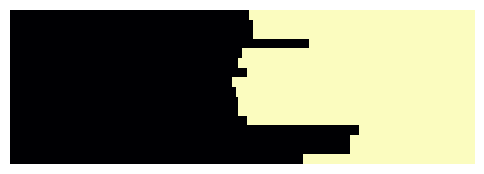

In [40]:
_,ax = plt.subplots(figsize=(6,2))
# ax.axvline(120,c='white')
# ax.matshow(sz_smooth.loc[time_mask[onset_idx:],:].T,aspect='auto')
ax.matshow(sz_smooth.loc[time_mask,elements_sorted].T,aspect='auto')
ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines.values():
            spine.set_visible(False)

(340.0, 354.5)

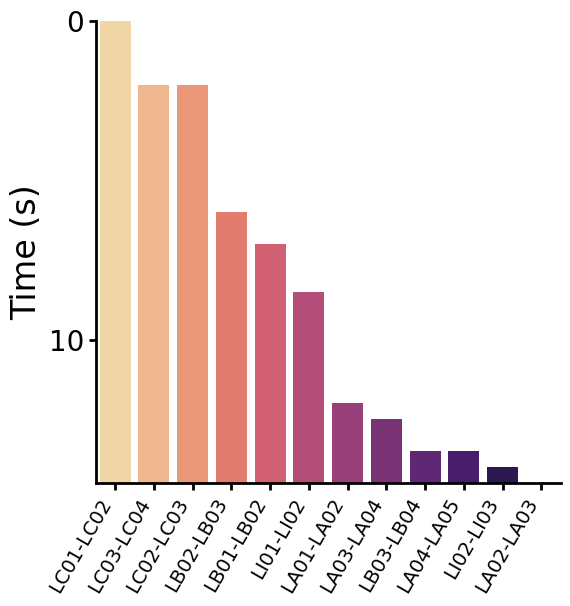

In [53]:
plt.figure(figsize=(6,6))
early_spread = sz_spread.loc[:,sz_spread.loc[0,:].to_numpy() < 60]
idxs = early_spread.to_numpy().reshape(-1,)
idxs -= min(idxs)
sz_ch_arr = early_spread.columns
# plt.bar(np.arange(len(idxs)),sz_times_arr[idxs],color='green')
plot_times_arr = max(sz_prob_times) - sz_prob_times
sns.barplot(x=np.arange(len(idxs)),y=plot_times_arr[idxs],palette='magma_r',orient='v')
sns.despine()
plt.xticks(np.arange(len(idxs)),sz_ch_arr,rotation=60,ha='right')
t = plt.yticks()
y_tix = max(sz_prob_times) - np.arange(0,221,10)
plt.yticks(y_tix,np.arange(0,221,10),fontsize=20)
# plt.axhline(max(sz_prob_times)-3,ls='--',color='red',linewidth=2)
# plt.axhline(max(sz_times_arr)-10,ls='--',color='blue',linewidth=2)
plt.ylabel("Time (s)",fontsize=24)
# plt.title('Seizure spread after onset',fontsize=28)
plt.ylim([max(sz_prob_times)-sz_prob_times[idxs[-1]],max(sz_prob_times)])

In [33]:
sz_spread = model.get_onset_and_spread(sz_prob)

## Plotting data variance

In [57]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))
consensus_annots = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
consensus_annots['Patient'] = consensus_annots['patient']
consensus_annots.sort_values('approximate_onset',inplace=True)

In [58]:
viz_data = pd.read_pickle(ospj(prodatapath,'onset_visualization_data.pkl'))
viz_data['State'] = viz_data['type'].map({'ueo':'Onset','inter':'Baseline','sec':'Spread'})
viz_data['patient'] = viz_data['Patient']
viz_data.loc[~viz_data.patient.isin(['HUP238','HUP253']),'patient'] = 'test'

In [59]:
def psd_fun(signal):
    return abs(sc.fft.fft(signal)[:128])
all_psds = []
for i,row in viz_data.iterrows():
    smooth_psd = sc.ndimage.uniform_filter1d(psd_fun(row.signal),5)
    all_psds.append(smooth_psd)
all_psd_array = np.vstack(all_psds)

In [60]:
len(viz_data)

997

### 2D Scatter and clustering

In [61]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding

In [62]:
mfld = TSNE(random_state=0)
embeddings = mfld.fit_transform(all_psd_array)
# mfld = SpectralEmbedding(random_state=0)
# embeddings = mfld.fit_transform(all_psd_array)

In [63]:
# _,ax = plt.subplots(figsize=(6,7))
# sns.scatterplot(x=embeddings[:,1],y=embeddings[:,0],
# # hue=viz_data[viz_data.patient == 'test']['patient'],
# hue=viz_data.type=='inter',
# style=viz_data['State'],
# markers=['o','^','s'],
# # palette='rocket',
# # palette=sns.color_palette("ch:s=-.2,r=.6"),
# palette='Blues',
# legend=False,
# alpha=0.7,
# ax=ax)

# # sns.scatterplot(x=embeddings[viz_data.patient == 'HUP253',0],y=embeddings[viz_data.patient == 'HUP253',1],
# # hue=viz_data[viz_data.patient == 'HUP253']['State'],
# # style=viz_data[viz_data.patient == 'HUP253']['State'],
# # hue_order=['Normal','Onset','Spread'],
# # markers=['o','^','s'],
# # palette='spring_r',
# # legend=False,
# # ax=ax,
# # s=60)

# pt2='HUP250'
# sns.scatterplot(x=embeddings[viz_data.Patient == pt2,1],y=embeddings[viz_data.Patient == pt2,0],
# markers=['o','^','s'],
# hue=viz_data[viz_data.Patient == pt2]['State'],
# style=viz_data[viz_data.Patient == pt2]['State'],
# hue_order=['Baseline','Onset','Spread'],
# palette='rocket',
# legend=True,
# ax=ax,
# s=60)

# sns.despine()
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.xticks([])
# plt.yticks([])
# plt.title('Embeddings of Neural Spectra')

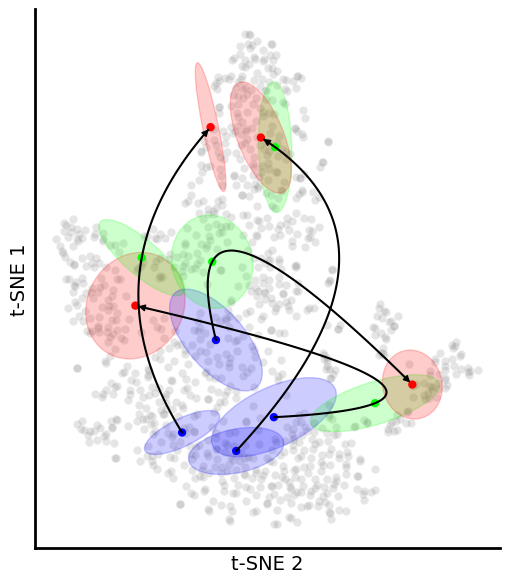

In [64]:
x=embeddings[:,1]
y=embeddings[:,0]
xy = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))

# Compute centroids of each state across all patients
centroid_points = np.array([xy[viz_data["State"] == state].mean(axis=0) for state in ['Baseline','Onset','Spread']])

def plot_confidence_ellipse(cov, mean, ax, color, alpha=0.2):
    """Draw an ellipse representing the covariance matrix at the mean position."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 1]))  # Rotation angle
    width, height = 2 * np.sqrt(eigenvalues)  # Convert variances to width/height

    ellipse = patches.Ellipse(mean, width, height, angle, color=color, alpha=alpha, edgecolor=color)
    ax.add_patch(ellipse)

# Initialize plot
_,ax = plt.subplots(figsize=(6,7))

sns.scatterplot(x=x,y=y,
color='gray',
legend=False,
alpha=0.2,
ax = ax)

state_base_colors = {"Baseline": (0, 0, 1),  # Blue
                     "Onset": (0, 1, 0),    # Green
                     "Spread": (1, 0, 0)}   # Red


for i_pt,patient in enumerate(viz_data["Patient"].unique()):
    if patient in ['HUP225','HUP253','HUP246','HUP257']:
        a = 1
    else:
        continue

    mask = viz_data["Patient"] == patient
    patient_embeddings = np.hstack([x[mask].reshape(-1,1),y[mask].reshape(-1,1)])
    patient_states = viz_data["State"][mask]
    
    centroids = dict()
    for state in ['Baseline','Onset','Spread']:
        state_mask = patient_states == state
        mean = patient_embeddings[state_mask].mean(axis=0)
        centroids[state] = mean
        cov = np.cov(patient_embeddings[state_mask].T)  # Compute covariance
        plot_confidence_ellipse(cov, mean, ax, state_base_colors[state])


    for label,coord in centroids.items():
        ax.scatter(coord[0],coord[1],edgecolor='none',alpha=a,label=label,color=state_base_colors[label])
    
    # Sort centroids in order: baseline → onset → spread
    sorted_states = ['Baseline','Onset','Spread']
    sorted_centroids = np.array([centroids[state] for state in sorted_states if state in centroids])

    # ax.text(
    # sorted_centroids[-1, 0] + 1, sorted_centroids[-1, 1] + 1,  # Offset label slightly
    # patient, 
    # fontsize=10, color="black", fontweight="bold"
    # )

    # Fit a smoothed spline curve through centroids
    if len(sorted_centroids) > 1:
        spline_order = min(len(sorted_centroids) - 1, 3)
        tck, u = sc.interpolate.splprep([sorted_centroids[:, 0], sorted_centroids[:, 1]], k=spline_order,s=0.5)
        smooth_x, smooth_y = sc.interpolate.splev(np.linspace(0, 1, 100), tck)
        ax.plot(smooth_x[:-1], smooth_y[:-1], "black", linewidth=1.5,alpha=a)       
        ax.annotate(
        "", xy=(smooth_x[-1], smooth_y[-1]), xytext=(smooth_x[-3], smooth_y[-3]),
        arrowprops=dict(arrowstyle="-|>", color="black", lw=1,alpha=a)
    )

# Labels and legend
ax.set_xlabel("t-SNE 2")
ax.set_ylabel("t-SNE 1")
ax.set_xticks([])
ax.set_yticks([])
sns.despine()
plt.savefig(ospj(figpath,'patient_path_embedding.pdf'),bbox_inches='tight')

### Traces

Onset 107374.2078 LB03


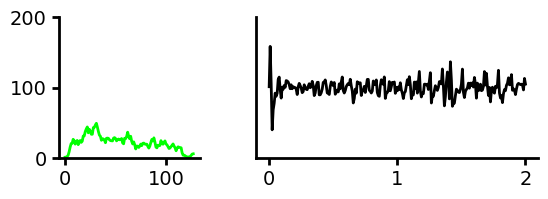

Onset 107374.2078 LC01


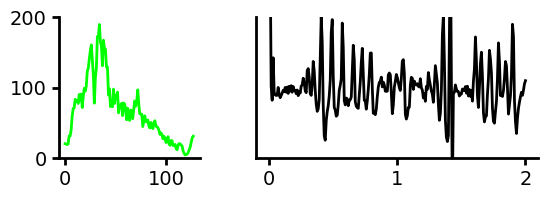

Spread 107374.2078 LB01


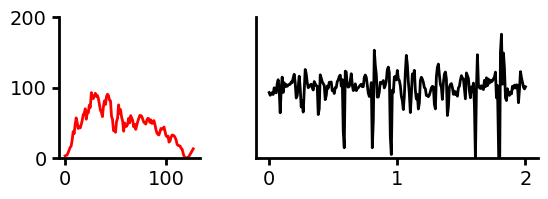

Spread 107374.2078 LB02


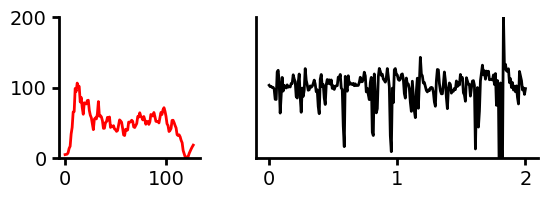

Spread 107374.2078 LB03


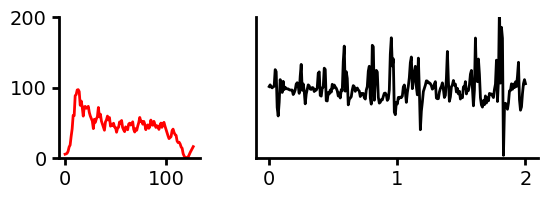

Spread 107374.2078 LB04


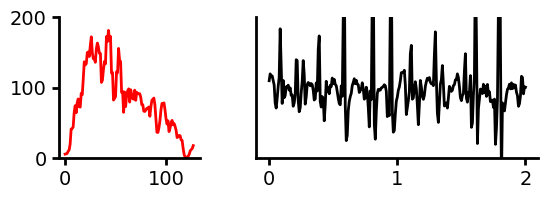

Spread 107374.2078 LC01


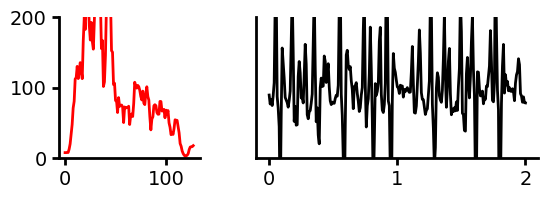

Spread 107374.2078 LC02


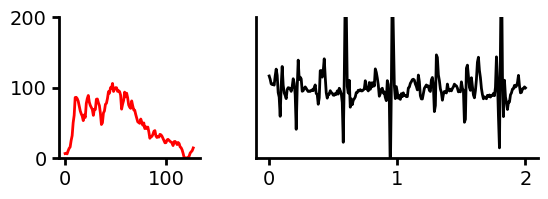

Baseline 107374.2078 LB01


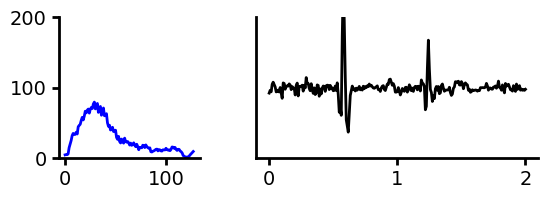

Baseline 107374.2078 LC01


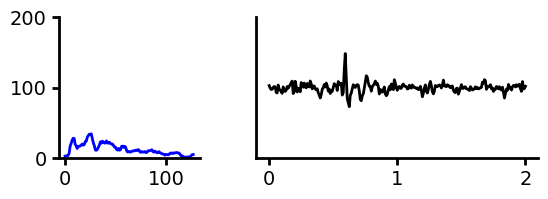

Baseline 107374.2078 LC02


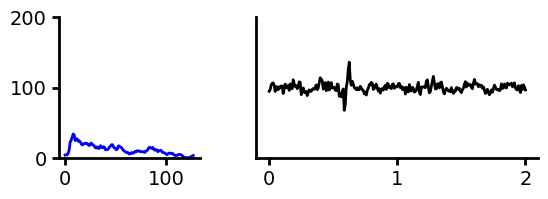

Baseline 107374.2078 LB02


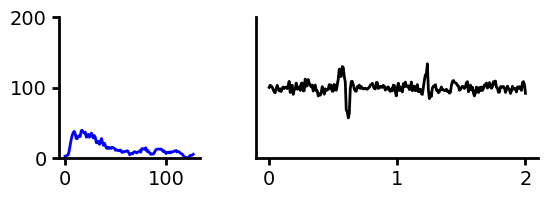

Baseline 107374.2078 LB03


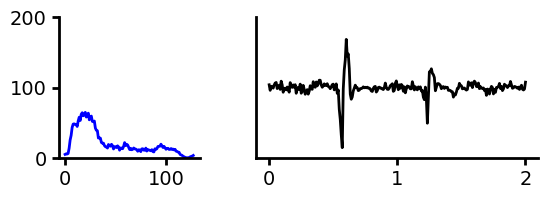

Baseline 107374.2078 LB04


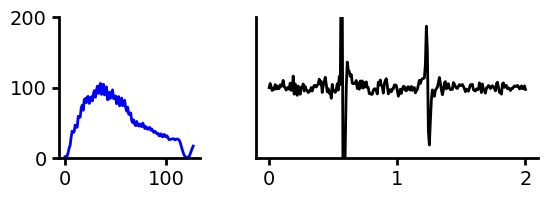

Onset 126735.81 LC01


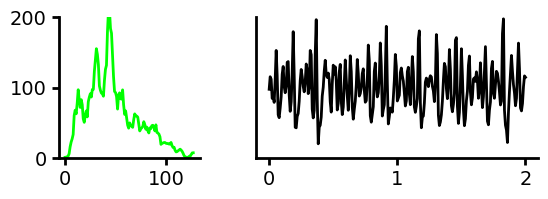

Spread 126735.81 LB02


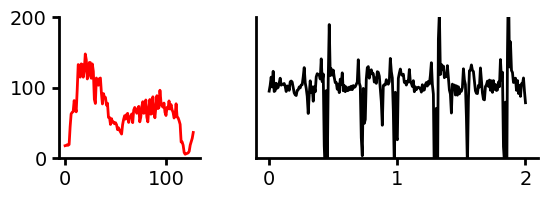

Spread 126735.81 LB03


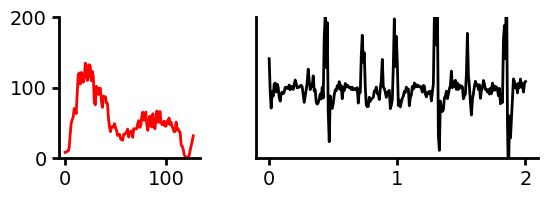

Spread 126735.81 LB04


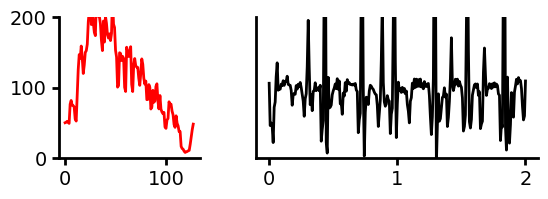

Spread 126735.81 LC01


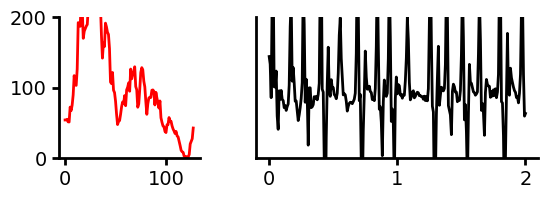

Spread 126735.81 LC02


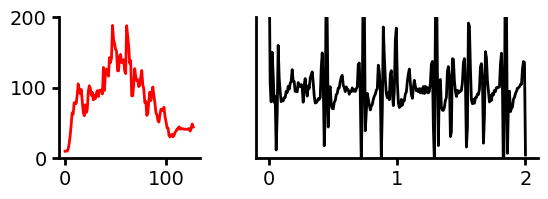

Baseline 126735.81 LC01


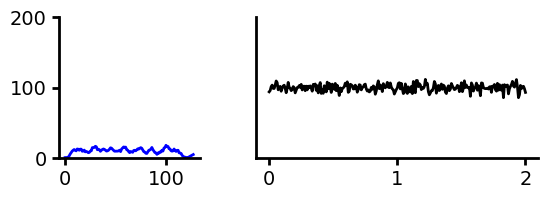

Baseline 126735.81 LC02


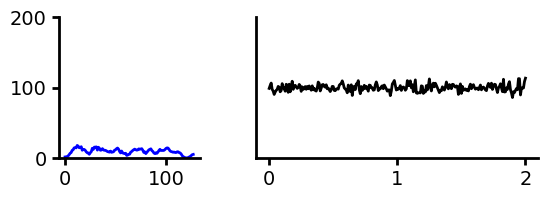

Baseline 126735.81 LB02


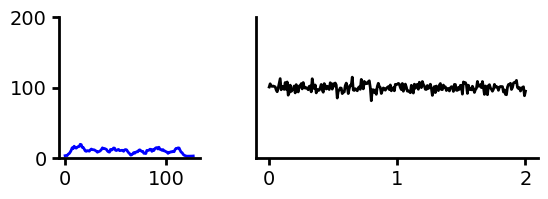

Baseline 126735.81 LB03


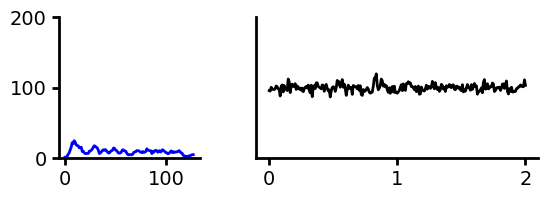

Baseline 126735.81 LB04


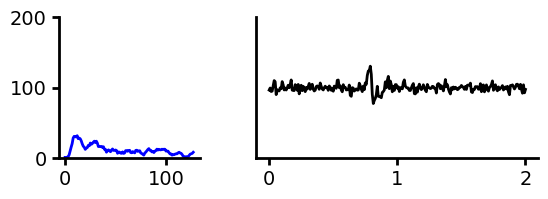

Onset 497084.3746 LC01


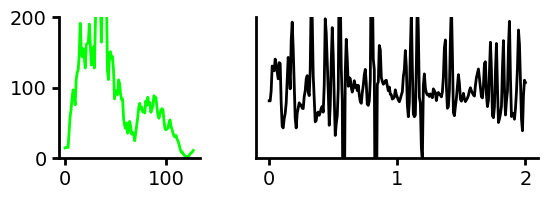

Spread 497084.3746 LB02


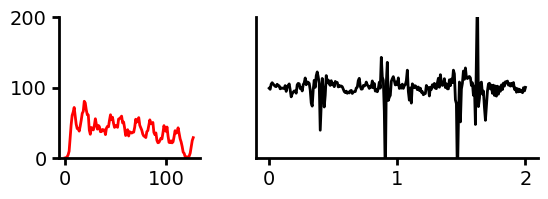

Spread 497084.3746 LB03


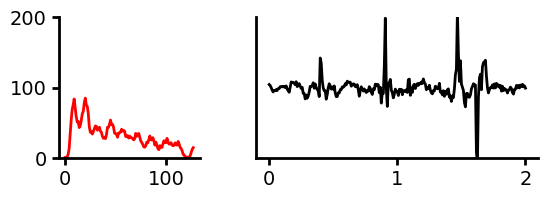

Spread 497084.3746 LB04


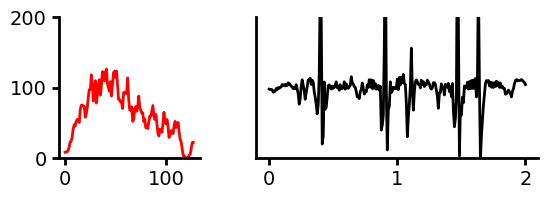

Spread 497084.3746 LC01


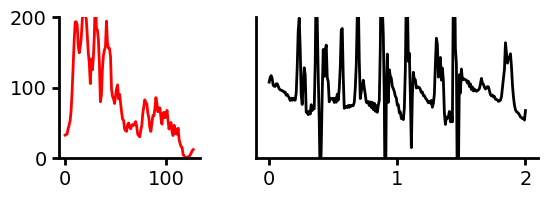

Spread 497084.3746 LC02


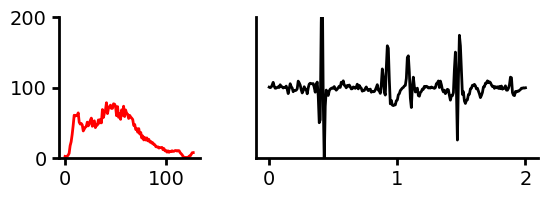

Baseline 497084.3746 LC01


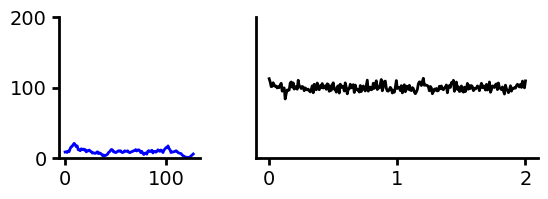

Baseline 497084.3746 LC02


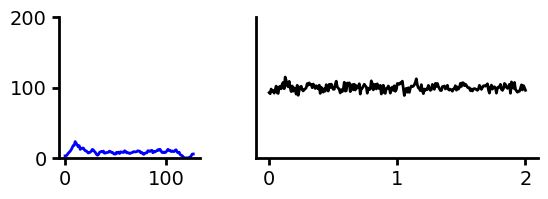

Baseline 497084.3746 LB02


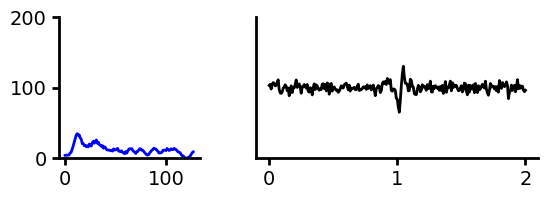

Baseline 497084.3746 LB03


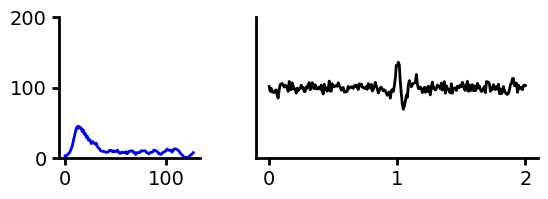

Baseline 497084.3746 LB04


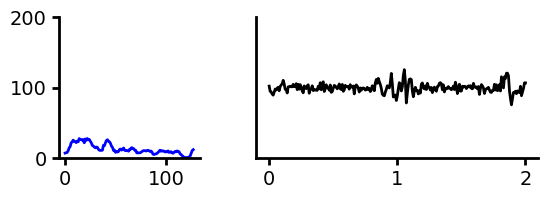

In [65]:
c_dict = {state: sns.color_palette('rocket',n_colors=3)[i] for i,state in enumerate(['Baseline','Onset','Spread'])}

for i,row in viz_data[viz_data.Patient == 'HUP235'].iterrows():
    print(row.State, row.approximate_onset, row.channel)
    # Create a figure
    fig = plt.figure(figsize=(6, 2),)

    # Define a GridSpec with 1 row and 4 columns
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

    # Create the square plot in the first column
    ax1 = fig.add_subplot(spec[0])
    ax1.plot(all_psd_array[i,:],c=state_base_colors[row.State])
    # ax1.set_title(row.State)
    ax1.set_ylim([0,200])
    ax1.set_box_aspect(1)  # Use set_box_aspect instead of set_aspect    # for spine in ax.spines.values():
    #         spine.set_visible(False)
    sns.despine(ax=ax1)
    # Create the rectangular plot spanning the remaining columns
    ax2 = fig.add_subplot(spec[1:])
    ax2.plot(row.signal,c='black')
    ax2.set_yticks([])
    ax2.set_xticks([0,128,256],[0,1,2])
    ax2.set_ylim([-15,15])
    # ax2.set_aspect('auto')  # For the rectangular plot
    ax2.set_box_aspect(1/2)
    sns.despine(ax=ax2)
    # fig.suptitle(row.State)
    plt.tight_layout()
    plt.show()
    # # Adjust layout and display
    # plt.tight_layout()
    # plt.show()

    # fig,axs = plt.subplots(1,2,figsize=(10,3))
    # axs[0].plot(row.signal)
    # axs[0].set_title(row.State)
    # axs[0].set_ylim([-10,10])
    # axs[1].plot(sc.ndimage.uniform_filter1d(all_psd_array[i,:],10))
    # axs[1].set_xscale('log')
    # axs[1].set_ylim([0,100])
    # plt.show()

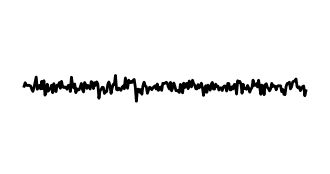

In [ ]:
_,ax = plt.subplots(figsize=(4,2))
plt.plot(viz_data[(viz_data.Patient=='HUP235') & (viz_data.State=='Baseline')].signal.iloc[8],c='black')
plt.ylim([-15,15])
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_eeg_trace.pdf'),bbox_inches='tight',transparent=True)

### 3D Scatter

In [ ]:
mfld = SpectralEmbedding(random_state=0,n_components=3)
embeddings = mfld.fit_transform(all_psd_array)

In [ ]:
embeddings.shape

(997, 3)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# fig = go.Figure(data=[go.Scatter3d(
#                                 x=embeddings[:,0],
#                                 y=embeddings[:,1],
#                                 z=embeddings[:,2],
#                                 mode='markers',
#                                 marker=dict(
#                                     symbol=['square' if i == 'Normal' else 'cross' for i in viz_data.State],
#                                     size=4,
#                                     color=viz_data.State.map({'Transition':1,'Seizure':2,'Normal':0}),
#                                     colorscale='Blues',
#                                     opacity=.1,
#                                     line={'width':0}
#                                 )
#                                 )])

# fig.update_layout(template='plotly_white',scene = dict(
#     xaxis = dict(showgrid = False,showticklabels = False),
#                                    yaxis = dict(showgrid = False,showticklabels = False),
#                                    zaxis = dict(showgrid = False,showticklabels = False)
#              ))